
# BLU14 - Exercise Notebook


In [1]:
import os
import base64
import joblib
import pandas as pd
import numpy as np
import category_encoders
import json
import joblib
import pickle
import math
import requests
from copy import deepcopy
import seaborn as sns
from uuid import uuid4

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

After the police, you nailed another big client. A bank hired you to assess whether or not a person is potentially a good client. For that purpose, they want you to design a system that tries to predict if a given individual earns more than 50K a year. You're no expert in the financial field, but you decide to take on the challenge. They provide you with a dataset of existing clients they have and their earnings.

<img src="media/banks.png" width=400 />


They also provide you with the following data description:

#### Attribute Information

    1) age - client's age
    2) workclass - type of work performed by the client (eg. `Private`)
    3) fnlwgt - final weight assigned by the Census Bureau: if two samples have the same (or similar) fnlwgt they have similar characteristics, demographically speaking
    4) education - level of education of client (eg. `Bachelors`)
    5) education-num - 
    6) marital-status - client's marital status (eg `Widowed`)
    7) occupation - type of job held by the client (eg. `Craft-repair`)
    8) relationship - 
    9) race - client's race
    10) sex - "male"/"female"
    11) capital-gain - total capital gain in the previous year
    12) capital-loss - total capital loss in previous year
    13) hours-per-week - number of hours the the client works per week
    14) native-country - client's original nationality (eg. `Portugal`)


**Note**: even if the dataset has values outside of the data dictionary, you should for these exercises consider the data dictionary as the source of truth.

Load the dataset below and check out its format:


In [2]:
def load_data():
    df = pd.read_csv(os.path.join("data", "bank.csv"))
    return df

df = load_data()
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Let's split our data into train and test:

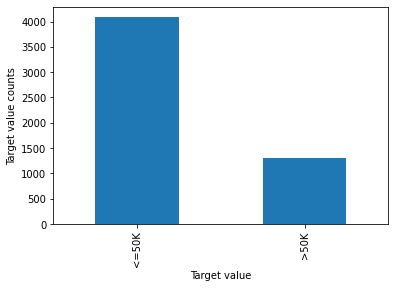

In [3]:
df = load_data()
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

df_test.salary.value_counts().plot(kind="bar");
plt.xlabel('Target value');
plt.ylabel('Target value counts');


### Q1)  

### Q1.a) Train a baseline model

Build a baseline model for this problem (don't worry about performance for now) and serialize it. Use the following features:

    1) age 
    2) workclass - type of work performed by the client (eg. `Private`)
    4) education - level of education of client (eg. `Bachelors`)
    6) marital-status - client's marital status (eg `Widowed`)
    9) race - client's race
    10) sex - "male"/"female"
    11) capital-gain - total capital gain in the previous year
    12) capital-loss - total capital loss in the previous year
    13) hours-per-week - number of hours the client works per week

Make sure to change the target so that it has a binary value - True or False - instead of the original values. In particular:

* False: client has as a salary of less than 50K
* True: client has as a salary higher or equal to 50K

**Note**: As we already provided the split, use the `df_train` to train your model.

**Note 2**: If you use models or functions that have a random component, ensure that you pass a random state so that there are no surprises when you submit.

In [4]:
# This is a temporary directory where your serialized files will be saved. Make sure you use this as 
# the target folder when you serialize your files
TMP_DIR = '/tmp'

In [5]:
TMP_DIR = '.'

In [6]:
# Write code to train and serialize a model in the block below
#
# Outputs expected: `columns.json`, `dtypes.pickle` and `pipeline.pickle`
#
# Your pipeline should be able to receive a dataframe with the columns we've requested you to use
# in the form `pipeline.predict(test_df)`
#

# YOUR CODE HERE

X_train = df_train[['age','workclass','education','marital-status','race','sex','capital-gain','capital-loss','hours-per-week']]
y_train = df_train.salary == '>50K' #df_train[['salary']].apply(lambda x: x == '>50K')

pipeline = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    LogisticRegression(max_iter=1000, solver='liblinear'),
)

pipeline.fit(X_train, y_train)

with open('columns.json', 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)
    
with open('dtypes.pickle', 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)
    
joblib.dump(pipeline, 'pipeline.pickle') 

['pipeline.pickle']

Test your procedure is correct by running the asserts below:

In [7]:
with open(os.path.join(TMP_DIR, 'columns.json')) as fh:
    columns = json.load(fh)
    assert columns == ["age", "workclass", "education", "marital-status", "race", "sex", "capital-gain", "capital-loss", "hours-per-week"]

with open(os.path.join(TMP_DIR, 'dtypes.pickle'), 'rb') as fh:
    dtypes = pickle.load(fh)
    assert dtypes.apply(lambda x: str(x)).isin(["int64", "int32", "object"]).all()

with open(os.path.join(TMP_DIR, 'pipeline.pickle'), 'rb') as fh:
    pipeline = joblib.load(fh)
    assert isinstance(pipeline, Pipeline)
    assert pipeline.predict(pd.DataFrame([{
        "age": 23, 
        "workclass": "Private", 
        "education": "Bachelors", 
        "marital-status": "Widowed", 
        "race": "White",
        "sex": "male",
        "capital-gain": 0, 
        "capital-loss": 0, 
        "hours-per-week": 40}
    ], columns=columns).astype(dtypes)) in [0, 1]

### Q1.b) Client requirements


Now, the client asks you one more thing. They want to make sure your model is as good at retrieving male cases of high salary as it is retrieving female cases. 

For example, if we have a pool of clients where 100 male clients earn more than 50K and we retrieve 80 out of those, and where 100 female patients also earn more than 50K but we only return 20 from those, then you're discriminating and that's not ok. A similar proportion, such as 75 women out of the 100 that earn higher, is expected.

Build a small function to verify this. In particular, make sure that the difference in percentage points is not higher than 10:

In [8]:
def verify_retrieve_rates(X_test, y_true, y_test):
    """
    Verify retrieval rates for different `sex` instances are 
    not different by more than 10 percentage points
    
    Inputs:
        X_test: features for the test cases
        y_true: true labels for the test cases [0, 1]
        y_test: predictions for the test cases [0, 1]

    Returns: tuple of (success, rate_difference)
        success: True if the condition is satisfied, otherwise False
        rate_difference: difference between each class retrieval rates (as an absolute value) 
        
    """
    # YOUR CODE HERE
    
    sensitive_classes = ['Male', 'Female'] #X_test['sex'].unique()
    
    mask = X_test['sex'] == 'Male'
    male_precision = recall_score(y_true[mask], y_pred[mask])
    
    
    mask = X_test['sex'] == 'Female'
    female_precision = recall_score(y_true[mask], y_pred[mask])
    
    diff = abs(male_precision - female_precision)
    threshold = True if diff <= 0.1 else False
    
    return (threshold, diff)

Verify your function is working on a couple of models.

In [9]:

model_1 = pd.read_csv(os.path.join('data', 'data_model_1.csv'))

X_test = model_1.copy().drop(columns=['target', 'prediction'])
y_test = model_1.target
y_pred = model_1.prediction

success, rate_diff = verify_retrieve_rates(X_test, y_test, y_pred) 

assert success is False
assert math.isclose(rate_diff, 0.55)

model_2 = pd.read_csv(os.path.join('data', 'data_model_2.csv'))

X_test = model_2.copy().drop(columns=['target', 'prediction'])
y_test = model_2.target
y_pred = model_2.prediction

success, rate_diff = verify_retrieve_rates(X_test, y_test, y_pred) 

assert success is True
assert math.isclose(rate_diff, 0.050000000000000044)


If you passed the asserts, you've defused this task. Move forward to the next one.

<img src="media/client-specs.png" width=400 />




<br>

### Q2) Prepare the model to be served


Now, use the model that you built for Q1 and build a predict function around it that will parse the request and return the respective prediction. Split your code into initialization and prediction code as you've learned. Additionally, instead of returning 0 or 1, return True or False. Do not worry about potential bad inputs at this point, we'll get to it later on.



In [10]:
# Initialization code

# YOUR CODE HERE
with open('columns.json') as fh:
    columns = json.load(fh)

with open('dtypes.pickle', 'rb') as fh:
    dtypes = pickle.load(fh)
    
#pipeline = joblib.load('pipeline.pickle')


def predict(request):
    """
    Produce prediction for request.
    
    Inputs:
        request: dictionary with format described below
        
        ```
        {
            "observation_id": <id-as-a-string>,
            "data": {
                "age": <value>,
                "sex": <value>,
                "race": <value>,
                "workclass": <value>,
                "education": <value>,
                "marital-status": <value>,
                "capital-gain": <value>,
                "capital-loss": <value>,
                "hours-per-week": <value>,
            }
        }
        ```
    
    Returns:
        response: A dictionary echoing the request and its data with the addition of the prediction and probability 
            ```
            {
                "observation_id": <id-of-request>,
                "age": <value-of-request>,
                "sex": <value-of-request>,
                "race": <value-of-request>,
                "workclass": <value-of-request>,
                "education": <value-of-request>,
                "marital-status": <value-of-request>,
                "capital-gain": <value-of-request>,
                "capital-loss": <value-of-request>,
                "hours-per-week": <value-of-request>,
                "prediction": <True|False>,
                "probability": <probability generated by model>
            }
            ```
    """
    # YOUR CODE HERE

    data = request['data']
    data["observation_id"] = request["observation_id"]
    
    obs = pd.DataFrame([data], columns=columns).astype(dtypes)
    proba = pipeline.predict_proba(obs)[0, 1]
    
    
    data["probability"] = proba
    data["prediction"] = True if proba >= 0.5 else False
    
    return data

Test your function on the code below:

In [11]:

request = {
    "observation_id": "1",
    "data": 
        {
            "age": 30, 
            "workclass": "Private", 
            "sex": "Female", 
            "race": "Amer-Indian-Eskimo", 
            "education": "Masters", 
            "marital-status": "Never-married", 
            "capital-gain": 0, 
            "capital-loss": 0, 
            "hours-per-week": 45, 
        }
}

response = predict(request)
assert sorted(response.keys()) == \
    sorted(["observation_id", "age", "sex", "race", "education", "marital-status", "workclass",
            "capital-gain", "capital-loss", "hours-per-week", "prediction", "probability"])

assert response["observation_id"] == "1"
assert response["age"] == 30
assert response["hours-per-week"] == 45
assert response["prediction"] in [True, False]

probability_1 = response["probability"] 


request = {
    "observation_id": "2",
    "data": 
        {
            "age": 44, 
            "workclass": "Private", 
            "sex": "Male", 
            "race": "White", 
            "education": "Some-college", 
            "marital-status": "Married-civ-spouse", 
            "capital-gain": 0, 
            "capital-loss": 0, 
            "hours-per-week": 40, 
        }
}

response = predict(request)
assert sorted(response.keys()) == \
    sorted(["observation_id", "age", "sex", "race", "education", "marital-status", "workclass",
            "capital-gain", "capital-loss", "hours-per-week", "prediction", "probability"])

assert response["observation_id"] == "2"
assert response["education"] == "Some-college"
assert response["hours-per-week"] == 40
assert response["prediction"] in [True, False]

probability_2 = response["probability"] 

assert probability_1 != probability_2



Hurray! It passed the tests. 


<br>

### Q3) Protecting our server

Let's be a bit more thorough with our server. To avoid issues and ensure we have full control around what is going on, we need to reason about which values we expect to receive and in what format.



<img src="media/darth-vader-validation.jpg" width=400 />



#### Q3.1) Categorical values

First, we'll reason about categorical values. As the name indicates, these are the values that are restricted to a set of potential choices. So logically, what we want to verify when one of these arrives at our server, is that they belong to the correct range. 

Create a function that given a column and a dataframe, obtains the list of possible values for it:


In [12]:
def get_valid_categories(df, column):
    """
    Obtain list of available categories for column
    
    Inputs:
        df (pandas.DataFrame): dataframe from which to extract column values
        column (str): target column for which to extract values
    
    Returns:
        categories: A list of potential values for column
    """

    # YOUR CODE HERE   
    return list(df[column].unique())
    

Test your function below:

In [13]:
df = load_data()

# Test dataframe categorical values
assert get_valid_categories(df, "sex") == ["Male", "Female"]
assert get_valid_categories(df, "race") ==  ["White", "Black", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other"]
assert len(get_valid_categories(df, "workclass")) == 9
assert len(get_valid_categories(df, "education")) == 16
assert len(get_valid_categories(df, "marital-status")) == 7


# Test dataframe numerical values - notice the amount of potential different values
assert len(get_valid_categories(df, "age")) == 71
assert len(get_valid_categories(df, "capital-loss")) == 83
assert len(get_valid_categories(df, "hours-per-week")) == 90
assert len(get_valid_categories(df, "capital-gain")) == 116



#### Q3.2) Numerical values

Now we'll look into numerical values. Even though you used the categorical approach to assess them in the last cell, it should be obvious why that's not the best idea for validation. First, the amount of values might easily explode, depending on the scenario. And second, we don't really want to exclude potentially new values that can be interpreted by the model.

For these values, it's better to reason and set proper expectations so that the model still behaves. Sometimes these can be set intuitively:


**Q3.2.i)** For example, which age range do you think is most adequate?

- A) -100 to 100
- B) 0 to 100
- C) 20 to 1000

Enter your answer below wrapped by quotes, for example:

```
answer_q32i = "A"
```

In [14]:
answer_q32i ='B'

# YOUR CODE HERE

In [15]:
assert base64.b64encode(answer_q32i.encode()) == b'Qg=='

However, not all features are that obvious and have ranges we can reason about. However, there are some strategies to go around it.

**Q3.2.ii)** Take for example capital gain, what do you think is most appropriate?

- A) Taking the minimum and maximum of the observed values and using them as a range
- B) Setting fixed values - eg. 0 to 10000
- C) Leaving the range of allowed values completely free of any specification

Enter your answer below wrapped by quotes, for example:

```
answer_q32ii = "A"
```

In [16]:
answer_q32ii = 'A' 

# YOUR CODE HERE

In [17]:
assert base64.b64encode(answer_q32ii.encode()) == b'QQ=='

#### Q3.3) Putting everything together

Now put everything together. Create a function similar to the one above and protect it against unexpected inputs. 

If everything is well with your request return an answer like this:

```json
{
    "observation_id": "id1234",
    "prediction": True,
    "probability": 0.4
}
```

However, if there is a problem with the initial data, such as missing fields or invalid values, we want to return a different response:

```json
{
    "observation_id": "id1234",
    "error": "Some error occured",
}
```


#### Hints 

- Hint 1: If the `observation_id` is not present, set it to None
- Hint 2: Check out the tests to see what we expect from the error cases and error messages
- Hint 3: Even though we mentioned better strategies above for values such as capital-gain and capital-loss, it's enough here to protect against what the tests show 


In [18]:
# Initialization code

# YOUR CODE HERE
with open('columns.json') as fh:
    columns = json.load(fh)

with open('dtypes.pickle', 'rb') as fh:
    dtypes = pickle.load(fh)
    
#pipeline = joblib.load('pipeline.pickle')


def attempt_predict(request):
    """
    Produce prediction for request.
    
    Inputs:
        request: dictionary with format described below
        
        ```
        {
            "observation_id": <id-as-a-string>,
            "data": {
                "age": <value>,
                "sex": <value>,
                "race": <value>,
                "workclass": <value>,
                "education": <value>,
                "marital-status": <value>,
                "capital-gain": <value>,
                "capital-loss": <value>,
                "hours-per-week": <value>,
            }
        }
        ```
     
    Returns: A dictionary with predictions or an error, the two potential values:
                if the request is OK and was properly parsed and predicted:
                ```
                {
                    "observation_id": <id-of-request>,
                    "prediction": <True|False>,
                    "probability": <probability generated by model>
                }
                ```
                otherwise:
                ```
                {
                    "observation_id": <id-of-request>,
                    "error": "some error message"
                }
                ```
    """

    # YOUR CODE HERE
    response = {}
    
    try:
        response["observation_id"] = request["observation_id"]
    except:
        response["observation_id"] = None
        response["error"] = "Unavailable observation_id"
        return response
    
    # Retrieve request columns from 'data'
    try:
        request_columns = list(request["data"].keys())
    except:
        response["error"] = "data does not exist"
        return response
        
    
    # Check all requested columns are valid
    valid_columns = ["age", "sex", "race", "workclass", "education", "marital-status", "capital-gain", "capital-loss", "hours-per-week"]    
    for column in request_columns:
        if (column != "observation_id" and 
            column != "probability" and
            column != "prediction" and
            column not in valid_columns):
            response["error"] = column + " is not a valid column"
            return response
        
    # Check if there are missing columns
    for column in valid_columns:
        if(column not in request_columns):
            response["error"] = column + " column is missing"
            return response

    # Check if 'sex' column matches expected input
    if request["data"]["sex"].lower() not in ['male', 'female'] :
        response["error"] = "Unexpected " + request["data"]["sex"] + " category on 'sex' column"
        return response
    
    # Check if 'race' column matches expected input
    if request["data"]["race"].lower() not in ['white', 'black', 'asian-pac-islander', 'amer-indian-eskimo', 'other']:
        response["error"] = "Unexpected " + request["data"]["race"] + " category on 'race' column"
        return response
    
    # Check if 'age' column matches expected input
    age = int(request["data"]["age"])
    if age < 0 or age > 100:
        response["error"] = "Unexpected 'age' of " + str(age) + " years old"
        return response
    
    # Check if 'capital-gain' column matches expected input
    capital_gains = float(request["data"]["capital-gain"])
    if capital_gains < 0: # or capital_gains > 99999:
        response["error"] = "Column 'capital-gain' of " + str(capital_gains) + " exceed bounds."
        return response
    
    # Check if 'capital-loss' column matches expected input
    capital_loss = float(request["data"]["capital-loss"])
    if capital_loss < 0:# or capital_loss > 4356:
        response["error"] = "Column 'capital-loss' of " + str(capital_loss) + " exceed bounds."
        return response

    # Check if 'hours-per-week' column matches expected input
    hours_per_week = int(request["data"]["hours-per-week"])
    if hours_per_week < 0 or hours_per_week > 168:
        response["error"] = "Column 'hours-per-week' of " + str(hours_per_week) + " exceed bounds."
        return response
    
    predict_response = predict(request)    
    response["prediction"] = predict_response["prediction"]
    response["probability"] = predict_response["probability"]    
    
    
    return response


Run the tests below to validate your function is protected against some simple cases:

In [19]:
################################################
# Test with good payload
################################################

base_request = {
    "observation_id": "1",
    "data": 
        {
            "age": 30, 
            "workclass": "Private", 
            "sex": "Female", 
            "race": "Amer-Indian-Eskimo", 
            "education": "Masters", 
            "marital-status": "Never-married", 
            "capital-gain": 0, 
            "capital-loss": 0, 
            "hours-per-week": 45, 
        }
}

response = attempt_predict(base_request)
assert 'prediction' in response, response
assert 'probability' in response, response
assert 'observation_id' in response, response

assert response["observation_id"] == "1", response["observation_id"]
assert response["prediction"] in [True, False], response["prediction"] 
assert response["probability"] <= 1.0, response["probability"] 
assert response["probability"] >= 0.0, response["probability"] 


################################################
# Test missing `observation_id` produces an error
################################################

bad_request_1 = deepcopy(base_request)
bad_request_1['random_field'] = bad_request_1.pop('observation_id')

response = attempt_predict(bad_request_1)
assert 'error' in response, response
assert 'observation_id' in response['error'] 


################################################
# Test missing `data` produces an error
################################################

bad_request_2 = deepcopy(base_request)
bad_request_2['data_field_name'] = bad_request_2.pop('data')

response = attempt_predict(bad_request_2)
assert 'error' in response, response
assert 'data' in response['error'] 


################################################
# Test missing columns produce an error
################################################

bad_request_3 = deepcopy(base_request)
bad_request_3['data'].pop('age')

response = attempt_predict(bad_request_3)
assert 'error' in response, response
assert 'age' in response['error'], response['error']


################################################
# Test extra columns produce an error
################################################

bad_request_4 = deepcopy(base_request)
bad_request_4['data']['relationship'] = "Wife"

response = attempt_predict(bad_request_4)
assert 'error' in response, response
assert 'relationship' in response['error'], response['error']


Run a couple more tests to make sure your server is bulletproof:

In [20]:

####################################################
# Test invalid values for categorical features - sex
####################################################

bad_request_5 = deepcopy(base_request)
bad_request_5['data']['sex'] = "Engineeer"

response = attempt_predict(bad_request_5)
assert 'error' in response, response
assert 'sex' in response['error'], response['error']
assert 'Engineeer' in response['error'], response['error']


###########################################################################
# Test invalid values for categorical features - race
###########################################################################

bad_request_6 = deepcopy(base_request)
bad_request_6['data']['race'] = 'Male'

response = attempt_predict(bad_request_6)
assert 'error' in response, response
assert 'race' in response['error'], response['error']
assert 'Male' in response['error'], response['error']


####################################################
# Test invalid values for numerical features - age
####################################################

bad_request_7 = deepcopy(base_request)
bad_request_7['data']['age'] = -12

response = attempt_predict(bad_request_7)
assert 'error' in response, response
assert 'age' in response['error'], response['error']
assert '-12' in response['error'], response['error']

bad_request_8 = deepcopy(base_request)
bad_request_8['data']['age'] = 1200

response = attempt_predict(bad_request_8)
assert 'error' in response, response
assert 'age' in response['error'], response['error']
assert '1200' in response['error'], response['error']


####################################################
# Test invalid values for numerical features - capital gain and loss
####################################################

bad_request_9 = deepcopy(base_request)
bad_request_9['data']['capital-gain'] = -10

response = attempt_predict(bad_request_9)
assert 'error' in response, response
assert 'capital-gain' in response['error'], response['error']
assert '-10' in response['error'], response['error']

bad_request_10 = deepcopy(base_request)
bad_request_10['data']['capital-loss'] = -500

response = attempt_predict(bad_request_10)
assert 'error' in response, response
assert 'capital-loss' in response['error'], response['error']
assert '-500' in response['error'], response['error']


####################################################
# Test invalid values for numerical features - hours per week
####################################################

bad_request_11 = deepcopy(base_request)
bad_request_11['data']['hours-per-week'] = -10

response = attempt_predict(bad_request_11)
assert 'error' in response, response
assert 'hours-per-week' in response['error'], response['error']
assert '-10' in response['error'], response['error']

bad_request_12 = deepcopy(base_request)
bad_request_12['data']['hours-per-week'] = 400

response = attempt_predict(bad_request_12)
assert 'error' in response, response
assert 'hours-per-week' in response['error'], response['error']
assert '400' in response['error'], response['error']



Ufff. That was tough. But now your app is a bit safer to deploy! At least from all the cases we could think of.

<img src="media/code-passes-tests.png" width=500 />


<br>

### Q4) Put everything together

Finally, build a server with your model and a predict endpoint protected from all the cases before. Deploy it and set 
the name of your app below:

In [21]:
# Assign the variable APP_NAME to the name of your heroku app
APP_NAME = 'e6281d438ef244b3b42f775aae'

# YOUR CODE HERE


Test that your server is bulletproof:

In [22]:
# Test locally
# url = f"http://localhost:5000/predict"


# Testing the predict/update endpoint
url = "https://{}.herokuapp.com/predict".format(APP_NAME)


################################################
# Test with good payload
################################################

payload = {
    "observation_id": str(uuid4()),
    "data": 
        {
            "age": 30, 
            "workclass": "Private", 
            "sex": "Female", 
            "race": "Amer-Indian-Eskimo", 
            "education": "Masters", 
            "marital-status": "Never-married", 
            "capital-gain": 0, 
            "capital-loss": 0, 
            "hours-per-week": 45, 
        }
}


r = requests.post(url, json=payload)
assert isinstance(r, requests.Response)
assert r.ok

response = r.json()

assert 'prediction' in response, response
assert 'probability' in response, response

assert response["prediction"] in [True, False]

assert isinstance(response["probability"], float)
assert 0 <= response["probability"] <= 1


################################################
# Test missing `observation_id` produces an error
################################################

bad_payload_1 = deepcopy(payload)
bad_payload_1['random_field'] = bad_payload_1.pop('observation_id')

r = requests.post(url, json=bad_payload_1)
assert isinstance(r, requests.Response)
assert r.ok

response = r.json()

assert 'error' in response, response
assert 'observation_id' in response['error'], response['error']


################################################
# Test missing `data` produces an error
################################################

bad_payload_2 = deepcopy(payload)
bad_payload_2['observation_id'] = str(uuid4())
bad_payload_2['random_field'] = bad_payload_2.pop('data')

r = requests.post(url, json=bad_payload_2)
assert isinstance(r, requests.Response)
assert r.ok

response = r.json()

assert 'error' in response, response
assert 'data' in response['error'], response['error']


################################################
# Test missing columns produce an error
################################################

bad_payload_3 = deepcopy(payload)
bad_payload_3['observation_id'] = str(uuid4())
bad_payload_3['data'].pop('age')

r = requests.post(url, json=bad_payload_3)
assert isinstance(r, requests.Response)
assert r.ok

response = r.json()

assert 'error' in response, response
assert 'age' in response['error'], response['error']


################################################
# Test extra columns produce an error
################################################

bad_payload_4 = deepcopy(payload)
bad_payload_4['observation_id'] = str(uuid4())
bad_payload_4['data']['relationship'] = "Wife"

r = requests.post(url, json=bad_payload_4)
assert isinstance(r, requests.Response)
assert r.ok

response = r.json()

assert 'error' in response, response
assert 'relationship' in response['error'], response['error']


###########################################################################
# Test invalid values for categorical features - race
###########################################################################


bad_payload_5 = deepcopy(payload)
bad_payload_5['observation_id'] = str(uuid4())
bad_payload_5['data']['race'] = 'Engineer'

r = requests.post(url, json=bad_payload_5)
assert isinstance(r, requests.Response)
assert r.ok

response = r.json()

assert 'error' in response, response
assert 'race' in response['error'], response['error']
assert 'Engineer' in response['error'], response['error']


####################################################
# Test invalid values for numerical features - age
####################################################

bad_payload_6 = deepcopy(payload)
bad_payload_6['observation_id'] = str(uuid4())
bad_payload_6['data']['age'] = -12

r = requests.post(url, json=bad_payload_6)
assert isinstance(r, requests.Response)
assert r.ok

response = r.json()

assert 'error' in response, response
assert 'age' in response['error'], response['error']
assert '-12' in response['error'], response['error']



And... you're done. You have successfully built a model, assessed if it passed the client requirements, built an app and protected it from crappy input. 

It's time for a well-deserved rest, so go ahead and go be a couch potato.

<br>

<img src="media/lays.png" width=400 />

